In [19]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Paths (relative to repo root / current working directory)
ROOT = Path.cwd()
OUT_DIR = ROOT / 'sex_behavior' / 'sex_behavior_analysis'
FIG_DIR = OUT_DIR / 'figs'
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load
df = pd.read_csv('nhanes_clean/NHANES2009-2012_sex_clean.csv')

# Enriquecer: bins de edad
df['age_bin'] = pd.cut(df['age'], bins=[10,20,30,40,50,60,80], right=False)

df.head()


,surveyyr,id,gender,age,sexever,sexage,sexnumpartnlife,sexnumpartyear,sexnumpartnlife_log1p,sexnumpartyear_log1p,sexage_z,age_bin
0,2009_10,51624,male,34,True,16.0,8.0,1.0,2.197225,0.693147,-0.373289,"[30, 40)"
1,2009_10,51630,female,49,True,12.0,10.0,1.0,2.397895,0.693147,-1.434231,"[40, 50)"
2,2009_10,51647,female,45,True,13.0,20.0,0.0,3.044522,0.000000,-1.168995,"[40, 50)"
3,2009_10,51654,male,66,True,17.0,15.0,NaN,2.772589,NaN,-0.108053,"[60, 80)"
4,2009_10,51656,male,58,True,22.0,7.0,1.0,2.079442,0.693147,1.218124,"[50, 60)"


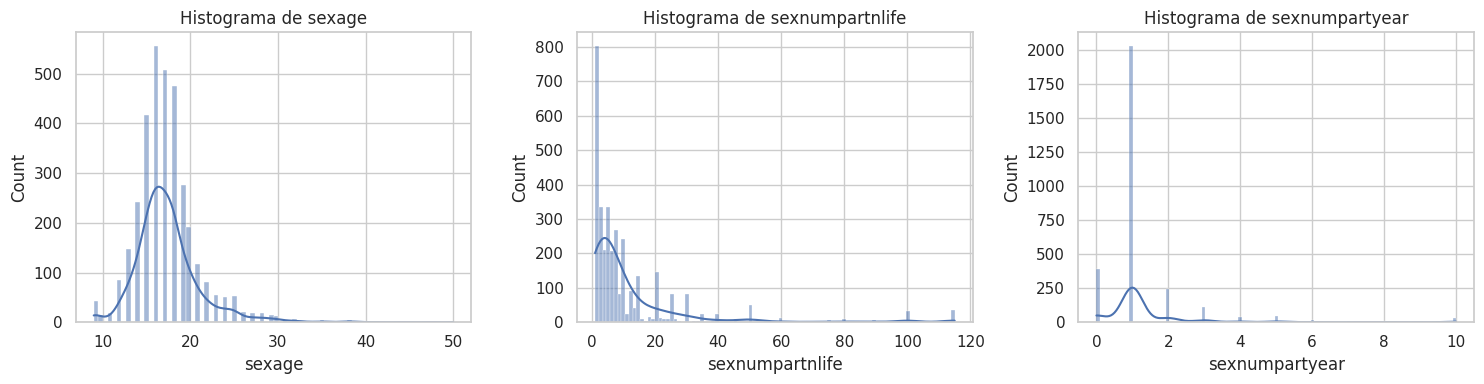

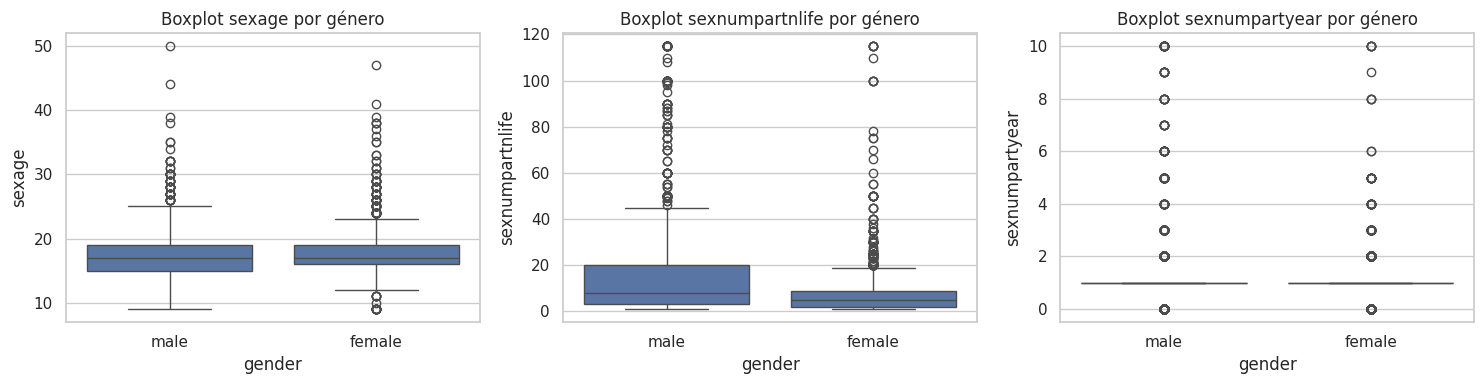

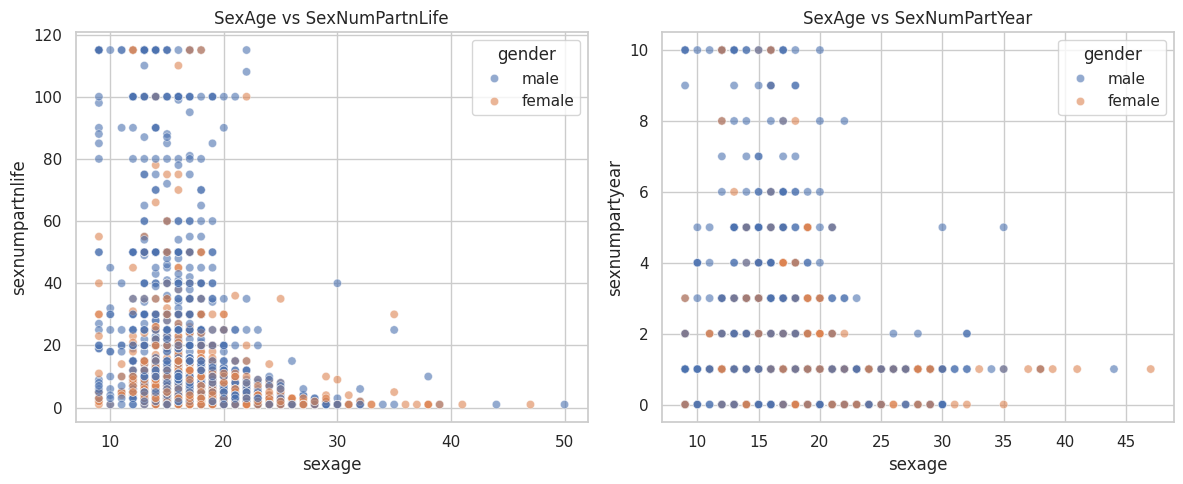

In [20]:
# EDA: histogramas y boxplots
sns.set(style='whitegrid')

# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ['sexage', 'sexnumpartnlife', 'sexnumpartyear']):
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f'Histograma de {col}')
plt.tight_layout()
plt.savefig(FIG_DIR / 'histograms_sex.png', dpi=150)
plt.show()

# Boxplots por género
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ['sexage', 'sexnumpartnlife', 'sexnumpartyear']):
    sns.boxplot(data=df, x='gender', y=col, ax=ax)
    ax.set_title(f'Boxplot {col} por género')
plt.tight_layout()
plt.savefig(FIG_DIR / 'boxplots_by_gender.png', dpi=150)
plt.show()

# Dispersión: SexAge vs parejas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df, x='sexage', y='sexnumpartnlife', hue='gender', alpha=0.6, ax=axes[0])
axes[0].set_title('SexAge vs SexNumPartnLife')
sns.scatterplot(data=df, x='sexage', y='sexnumpartyear', hue='gender', alpha=0.6, ax=axes[1])
axes[1].set_title('SexAge vs SexNumPartYear')
plt.tight_layout()
plt.savefig(FIG_DIR / 'scatter_sexage_pairs.png', dpi=150)
plt.show()


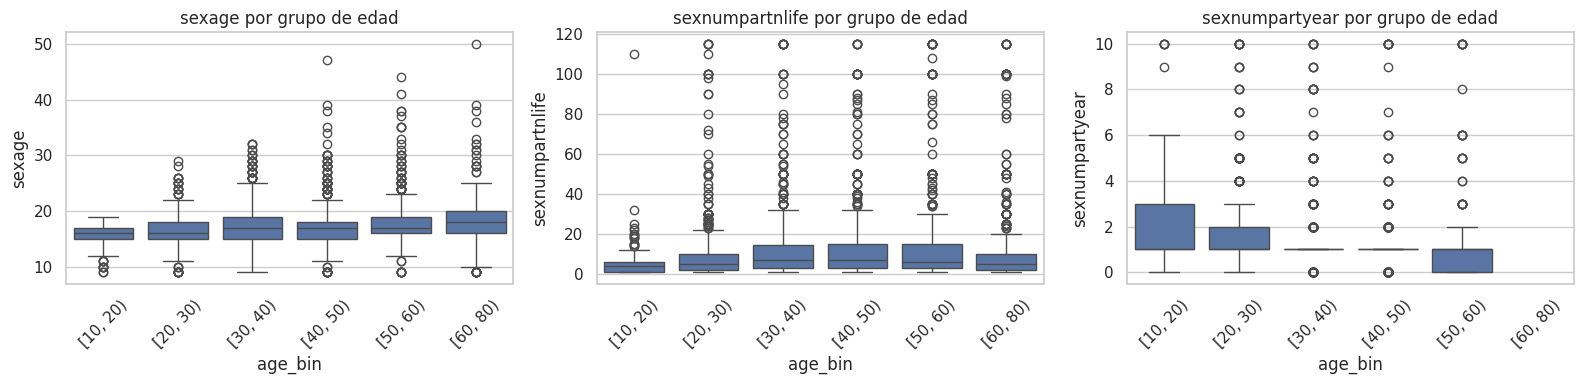

In [21]:
# Comparaciones por grupos (bins de edad)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, col in zip(axes, ['sexage', 'sexnumpartnlife', 'sexnumpartyear']):
    sns.boxplot(data=df, x='age_bin', y=col, ax=ax)
    ax.set_title(f'{col} por grupo de edad')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / 'boxplots_by_agebin.png', dpi=150)
plt.show()


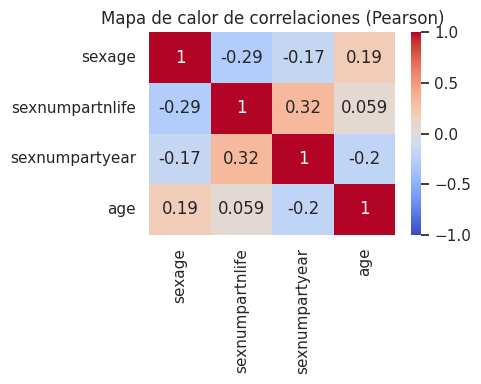

,sexage,sexnumpartnlife,sexnumpartyear,age
sexage,1.000000,-0.288948,-0.171701,0.194262
sexnumpartnlife,-0.288948,1.000000,0.323756,0.059338
sexnumpartyear,-0.171701,0.323756,1.000000,-0.201200
age,0.194262,0.059338,-0.201200,1.000000


In [22]:
# Correlaciones relevantes
# Seleccionamos numéricas
num_cols = ['sexage', 'sexnumpartnlife', 'sexnumpartyear', 'age']
num_cols = [c for c in num_cols if c in df.columns]

corr = df[num_cols].corr(method='pearson')

# Guardar tabla
corr_path = OUT_DIR / 'correlations_sex.csv'
corr.to_csv(corr_path)

# Mapa de calor
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlaciones (Pearson)')
plt.tight_layout()
plt.savefig(FIG_DIR / 'heatmap_correlations.png', dpi=150)
plt.show()

corr


In [23]:
# Predicción simple: predecir `sexnumpartyear` usando `sexage`, `gender`, `age`
# Preparamos X, y
if 'sexnumpartyear' in df.columns:
    model_df = df[['sexnumpartyear', 'sexage', 'gender', 'age']].dropna().copy()
    # Codificar género
    model_df['gender_male'] = (model_df['gender'].str.lower() == 'male').astype(int)

    X = model_df[['sexage', 'age', 'gender_male']]
    y = model_df['sexnumpartyear']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Regresión Lineal
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    # Árbol de decisión
    dt = DecisionTreeRegressor(random_state=42, max_depth=4)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)

    # Métricas
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
    results = pd.DataFrame({
        'model': ['LinearRegression', 'DecisionTree(max_depth=4)'],
        'rmse': [rmse_lr, rmse_dt],
        'r2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_dt)]
    })

    results_path = OUT_DIR / 'model_results_sex.csv'
    results.to_csv(results_path, index=False)
    results
else:
    print('No existe la columna objetivo sexnumpartyear en el CSV limpio.')
